In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## System definition and parameters

In [264]:
vmax = 1        # full velocity at crossing
amax = 0.5      # maximum acceleration/deceleration
L = 1           # follow distance = vehicle length
W = 0.25        # vehicle width
D = 10          # length of lane
rho = L / vmax  # follow time

In [3]:
def interval_controller(amax, *intervals):
    def evaluate(t):
        a = 0
        for ix, i in enumerate(intervals):
            if i[0] <= t < i[1]:
                a = -amax if (ix % 2 == 0) else amax
        return a

    return evaluate

def double_integrator(control):
    return lambda t, y: (y[1], control(t))

## Schedule time to regular time

In [4]:
T = vmax / amax
T_bar = T / 2
t = np.linspace(0, T, num=100)

In [5]:
def acceleration(t):
    return t*t * amax / 2

In [186]:
# distance of the first waiting vehicle to
# intersection is distance to fully accelerate
acceleration_distance = acceleration(T)

In [6]:
def t_bar(t, x):
    return t - x / vmax

In [7]:
def line(bar):
    return lambda t: (t - bar) * vmax

In [8]:
def t1_acc(v_c, d_bar):
    t0 = v_c / amax
    return T - math.sqrt(T*T - 2*T*(t0 + d_bar) + t0*t0)
def duration_acc(v_c, d_bar):
    t0 = v_c / amax
    return t1_acc(v_c, d_bar) - t0

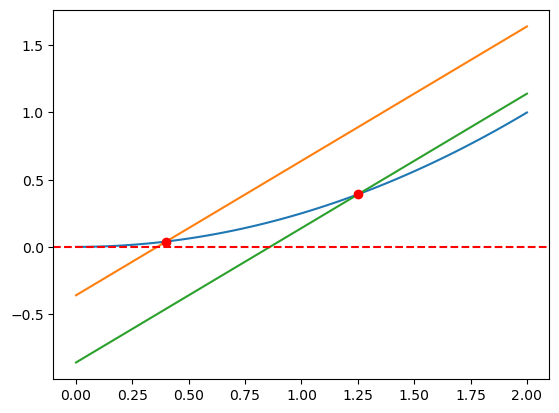

In [9]:
def plot_acceleration(v_c, d_bar):
    t0 = v_c / amax
    
    plt.plot(t, acceleration(t))
    plt.plot(t, line(t_bar(t0, acceleration(t0)))(t))
    plt.plot(t0, acceleration(t0), 'ro')
    t1 = t1_acc(v_c, d_bar)
    plt.plot(t, line(t_bar(t1, acceleration(t1)))(t))
    plt.plot(t1, acceleration(t1), 'ro')
    plt.axhline(y=0, color='r', linestyle='--')
plot_acceleration(0.2, 0.5)

In [10]:
def t1_dec(v_c, d_bar):
    t0 = -v_c / amax
    return -T + math.sqrt(T*T + 2*T*(t0 + d_bar) + t0*t0)
def duration_dec(v_c, d_bar):
    t0 = -v_c / amax
    return t1_dec(v_c, d_bar) - t0

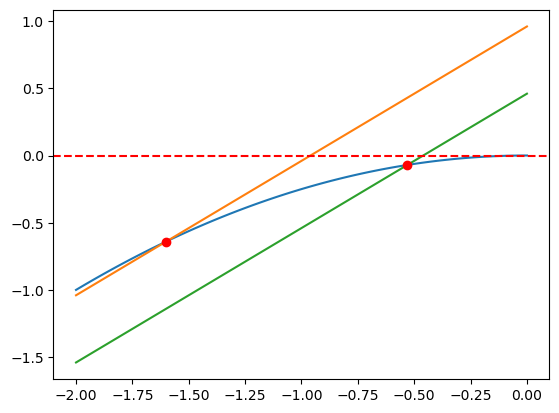

In [11]:
def plot_deceleration(v_c, d_bar):
    t0 = -v_c / amax
    
    plt.plot(-t, -acceleration(t))
    plt.plot(-t, line(t_bar(t0, -acceleration(t0)))(-t))
    plt.plot(t0, -acceleration(t0), 'ro')
    t1 = t1_dec(v_c, d_bar)
    plt.plot(-t, line(t_bar(t1, -acceleration(t1)))(-t))
    plt.plot(t1, -acceleration(t1), 'ro')
    plt.axhline(y=0, color='r', linestyle='--')
plot_deceleration(vmax-0.2, 0.5)

## Explicit expression for single trajectory

In [12]:
def simple_trajectory_intervals(b, e):
    t_n = max(0, e - b - T)
    t_b_bar = (e - b - t_n) / 2

    d_dec = duration_dec(vmax, t_b_bar)
    vc = vmax - d_dec * amax
    d_acc = duration_acc(vc, t_b_bar)
    
    return [[b, b+d_dec], [b+d_dec+t_n, b+d_dec+t_n+d_acc]]

def simple_trajectory(b, e):
    intervals = simple_trajectory_intervals(b, e)

    control = interval_controller(amax, *intervals)

    tr = solve_ivp(double_integrator(control), [0, 15], [-b*vmax, vmax], max_step=0.01)

    plt.plot(tr.t, tr.y[0,:])
    return tr

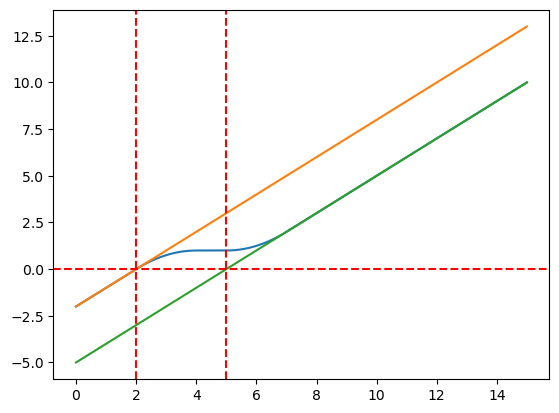

In [13]:
b, e = 2, 5

tr = simple_trajectory(b, e)
plt.plot(tr.t, line(t_bar(b, 0))(tr.t))
plt.plot(tr.t, line(t_bar(e, 0))(tr.t))
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=b, color='r', linestyle='--')
plt.axvline(x=e, color='r', linestyle='--');

## Translate sequence of schedule intervals

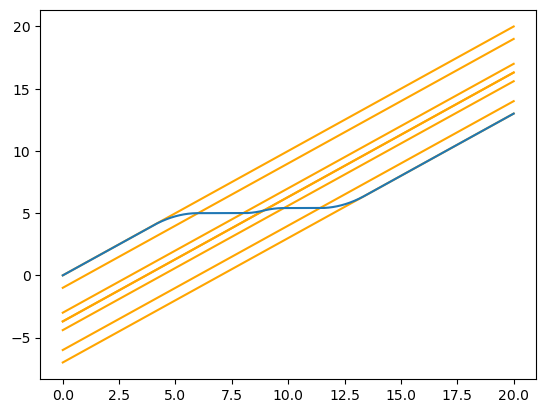

In [14]:
schedule_intervals = [[0, 1], [3, 3.7], [3.7, 4.4], [6, 7]]

def translate(schedule_intervals, target_height, vc=vmax):
    """vc = initial velocity"""
    intervals = []
    arrival = schedule_intervals[0][0]
    t = arrival + (target_height - acceleration(T)) / vmax
    prev = arrival
    for ix, (a, b) in enumerate(schedule_intervals):
        if prev != a:
            # duration when velocity is constant
            t += (a - prev) * vmax / (vmax - vc)
        if ix % 2 == 0:
            d = duration_dec(vc, b - a)
            vc -= d * amax
        else:
            d = duration_acc(vc, b - a)
            vc += d * amax

        intervals.append([t, t+d])
        t+=d
        prev = b

    return intervals
    
intervals = translate(schedule_intervals, 5)
control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 20], [-schedule_intervals[0][0]*vmax, vmax], max_step=0.001)

for a, b in schedule_intervals:
    plt.plot(tr.t, line(t_bar(a, 0))(tr.t), 'orange')
    plt.plot(tr.t, line(t_bar(b, 0))(tr.t), 'orange')

plt.plot(tr.t, tr.y[0,:]);

### Test next target position

In [15]:
t_hat = math.sqrt(L / amax) - L / 2 / vmax

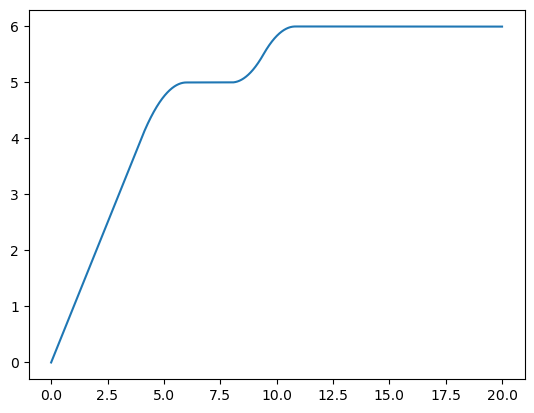

In [16]:
schedule_intervals = [[0, 1], [3, 3+t_hat], [3+t_hat, 3+2*t_hat]]
intervals = translate(schedule_intervals, 5)
control = interval_controller(amax, *intervals)
tr = solve_ivp(double_integrator(control), [0, 20], [-schedule_intervals[0][0]*vmax, vmax], max_step=0.001)

plt.plot(tr.t, tr.y[0,:]);

## Bang merging

In [223]:
def merge(intervals):
    """Merge schedule time intervals in-place."""
    n = len(intervals)
    for i, (a, b) in enumerate(zip(intervals[:n-1], intervals[1:])):
        if a[1] > b[0]: # overlap
            mid = (a[1] + b[0]) / 2
            a[1] = mid
            b[0] = mid
    return intervals

In [234]:
delta = L / vmax

def merge_prev(prev_intervals, a, y):
    """Computes the schedule `intervals` for a vehicle with arrival time `a`
    and crossing time `y` such that it respects the follow distance to
    the previous vehicle, which is defined by `prev_intervals`.
    Also computes `h`, the number of "places" to start before the intersection location.
    Returns (`intervals`, `h`)."""
    D_first = [a, a + T_bar]
    A_last = [y - T_bar, y]

    # obtain the AD-parts
    ADs = []
    prev_As = prev_intervals[1::2] # all odd bangs are acceleration
    for prev_A in prev_As:
        p = prev_A[0] + delta
        if a < p + 2 * t_hat - T_bar and p + T_bar < y:
            ADs.append([p, p + t_hat])
            ADs.append([p + t_hat, p + 2 * t_hat])
    return merge([D_first, *ADs, A_last]), len(ADs) / 2

Remaining points of attention:

- Automatically determine the parameters `solve_ivp()` (`t_span`, initial state `y0`).
- Truncate trajectories to arrival time and crossing time.
- Output intervals_regular.

In [243]:
def explicit_motion(arrivals, crossings, D):
    """Calculate trajectories without using time discretization, satisfying
    the MotionSynthesize formulation.

    Parameter `D` = location of the intersection."""
    trajectories = []
    prev_intervals = []
    for a, y in zip(arrivals, crossings):
        intervals, h = merge_prev(prev_intervals, a, y)
        target_height = D - acceleration_distance - h * L
        intervals_regular = translate(intervals, target_height)
        tr = solve_ivp(double_integrator(interval_controller(amax, *intervals_regular)),
                       [0, 20], [-intervals[0][0]*vmax, vmax], max_step=0.001)
        trajectories.append(tr)
        prev_intervals = intervals
    
    return trajectories

## Comparison to direct transcription

In [265]:
def capacity(D):
    """Compute lane capacity, given lane length `D`."""
    return math.floor((D - W - 2 * acceleration_distance) / L)

In [266]:
def extract_trajectories(trajectories, D, L):
    """Trim the positions (and corresponding time) to positions
    `(0, D)`, which is the current lane, for comparision."""
    out = []
    for tr in trajectories:
        y = tr.y[0,:]
        ix = np.logical_and(y >= 0, y <= D)
        ts = tr['t'][ix]
        ys = tr['y'][0, ix]
        out.append((ts, ys))
    return out

In [278]:
def draw_trajectories(trajectories, D, L, W):
    # plot intersections
    plt.axhline(y=0, color='r', linestyle='--', lw=1)
    plt.axhline(y=W, color='r', linestyle='--', lw=1)
    plt.axhline(y=D, color='r', linestyle='--', lw=1)
    
    # draw buffer positions
    for i in range(capacity(D)):
        plt.axhline(y=D - acceleration_distance - i * L, color='lightgrey', linestyle='--', lw=1)

    # draw the earliest possible stopping position
    #plt.axhline(y=W + L + acceleration_distance, color='lightblue', linestyle='-', lw=1)
    
    for tr in trajectories:
        plt.plot(*tr);

In [284]:
# specify in schedule time
arrivals_hat = [0, 2 * rho, 6 * rho]
crossings_hat = [4, 7, 10]
trajectories = explicit_motion(arrivals_hat, crossings_hat, D)

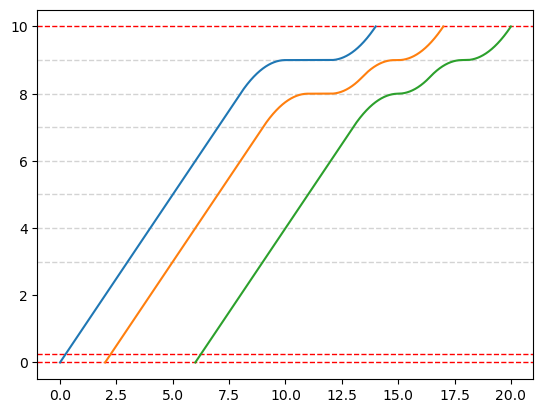

In [300]:
trs_explicit = extract_trajectories(trajectories, D, L)
draw_trajectories(trs_explicit, D, L, W)

Compute the same trajectories using direct transcription to linear program (using time discretization) to verify correctness of our explicit procedure. Using smaller discrete time step sizes gives more accurate results.

In [301]:
from motion import motion_synthesize

params = {
    'vmax': vmax, # maximum speed
    'umax': amax, # maximum acceleration
    'dt': 0.01,   # discrete time step size
    'l': L,       # vehicle length = minimum follow distance
}

# translate to regular times
arrivals = arrivals_hat
crossings = [ y + D * vmax for y in crossings_hat ]

x = []
prev = None
for a, y in zip(arrivals, crossings):
    checkpoints = np.array([
        (a, 0),
        (y, D),
    ])
    x.append(motion_synthesize(checkpoints, params, prev=prev))
    prev = (y, x[-1])

trs_transcription = []
# add the correct time scale
for traject, (a, y) in zip(x, zip(arrivals, crossings)):
    t = np.arange(a, y + params['dt'], params['dt'])
    ts = t[:len(traject)]
    ys = traject
    trs_transcription.append((ts, ys))

Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 8607
199 simplex iterations
1 branching node
absmipgap=9.09495e-12, relmipgap=0
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 9216.07755
563 simplex iterations
1 branching node
absmipgap=3.63798e-12, relmipgap=0
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 8415.57755
565 simplex iterations
1 branching node
absmipgap=7.27596e-12, relmipgap=0


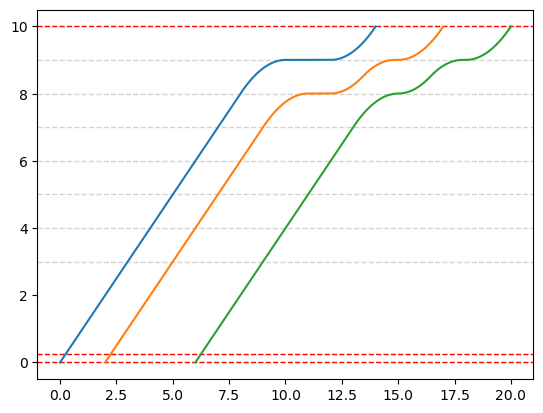

In [302]:
draw_trajectories(trs_transcription, D, L, W)

Compare the maximum absolute error. We need to take into account the different times scales: maybe use some kind of interpolation?

In [303]:
# compare trs_explicit, trs_transcription